#CNN for Crack Detection and Feature Extraction

---


José Pedro dos Santos Rodrigues                               up201806386                                        
Marina Rodrigues Brilhante        up201806386


---



This program is destined to the identification of cracks in civil infrastructures through the use of images. It is inserted in José's Master's Thesis and will be deployed into a Drone for infrastructure mapping.

It aims to use various techniques and multiple architectures of deep learning,addressed in this course, in order to present the best results. 
The dataset used will be composed of multiple images with binary labels (“Positive” or “Negative”) of different types of cracks with different orientations and extensions with the purpose of image classification.

For that end, we proposed the following solution:

1.   Implementation of a CNN for Image Classification
2.   Color Masking and Skeletonization for Crack's Feature Extraction



#Package Import

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install skan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 7.7 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 3.2 MB 48.5 MB/s 
     |████████████████████████████████| 100 kB 9.6 MB/s 
     |████████████████████████████████| 121 kB 70.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.4 MB/s 
     |████████████████████████████████| 133 kB 57.9 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 90 kB 10.6 MB/s 
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 

In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 7.7 MB/s 


In [5]:
import pathlib
import numpy
import pandas
import matplotlib
import matplotlib.pyplot
import seaborn
import cv2
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import torch
import torchvision
import torchsummary
import torchmetrics
import time

import PIL
import PIL.Image
import io

import skimage
import skimage.morphology
import skan
import skan.draw

#Generate Dataset

The Dataset that will be used is the "Surface Crack Detection Dataset" available on Kaggle:
https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

This Dataset contains Crack images in concrete walls divided into 2 Labels - "Positive" and "Negative" - each in its own folder for a total of 40 000 Images. Each Image is presented in RGB Color Space with 227 x 227 pixels

As we can see bellow, the Dataset is exactly balanced as the same number of samples exists for both Labels. This is indeed a good indicator of the good results presented in the Test Section.

By previewing some images, it is possible to detect however that those images lack quality, are very zoomed in and also lack some proper lighting in order to clearly detect the crack.

As the documentation implies and as the results shows, Data Augementation in terms of flipping and rotation is deemed not necessary.


In [6]:
dataset_path = "/content/drive/MyDrive/Data_ANN_Crack_Detection/Surface Crack Detection"

In [7]:
def generate_dataset(image_dir, label):
    """
    Create the DataFrame of the associated directory and label.
    """
    
    filepaths = pandas.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pandas.Series(label, name='Label', index=filepaths.index)
    
    dataset = pandas.concat([filepaths, labels], axis=1)
    
    return dataset

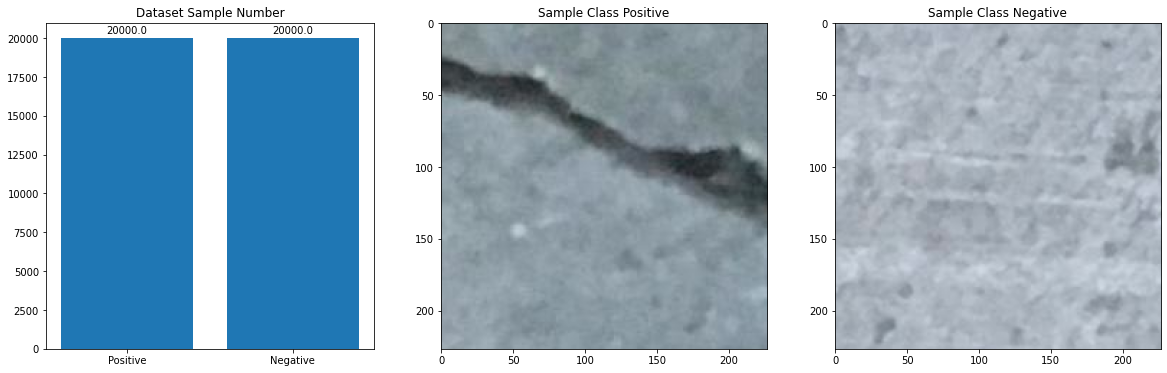

In [8]:
positiveDataset = generate_dataset(pathlib.Path("{0}/Positive".format(dataset_path)), 'Positive')
negativeDataset = generate_dataset(pathlib.Path("{0}/Negative".format(dataset_path)), 'Negative')

dataset = pandas.concat([positiveDataset, negativeDataset], ignore_index = False)

fig, axes = matplotlib.pyplot.subplots(1,3, figsize = (20,6))

plot = axes[0].bar(["Positive", "Negative"], [positiveDataset.shape[0], negativeDataset.shape[0]])

imgPos_path = positiveDataset.iloc[0]["Filepath"]
imgNeg_path = negativeDataset.iloc[0]["Filepath"]

imgPos = cv2.imread(imgPos_path)
imgNeg = cv2.imread(imgNeg_path)


axes[1].imshow(imgPos)
axes[2].imshow(imgNeg)

for rect in plot:
  height = rect.get_height()
  axes[0].text(rect.get_x() + rect.get_width()/2, 1.01*height, "{0:.1f}".format(height), ha = "center", va = "bottom")

axes[0].set_title("Dataset Sample Number")
axes[1].set_title("Sample Class Positive")
axes[2].set_title("Sample Class Negative")

matplotlib.pyplot.show()

#Create PyTorch Class Models

This program starts by creating the basic PyTorch Classes to work with the Dataset and implement the Model.

A third Class was also implemented called Iteration that would combine a Model Class and a Dataset Class for easy testing and comparison of parameters.

In [9]:
class Aux(torch.utils.data.Dataset):
 
  def __init__(self, pandasDataframe, transform):
    self.dataset = pandasDataframe
    self.transform = transform
              
  def __len__(self):
    return len(self.dataset)
   
  def __getitem__(self,index):
    x = PIL.Image.open(self.dataset.iloc[index,0])
    if self.transform:
      x = self.transform(x)
    y = self.dataset.iloc[index,1]
    return x,y

In [10]:
class customDataset(torch.utils.data.Dataset):
    
    def __init__ (self, problema = "Classificacao", dataset = None, 
                  YColumn = None, YLabel_Column = None, XColumns_Encode = None,
                  imgPath = None, mode = "Dados", testFactor = 0.3, batch_size = 128,
                  augementation = True,
                  img_width = 227, img_height = 227, seed = None):
        
        if (mode == "Dados"):
            self.mode = "Dados"
        elif (mode == "Imagem"):
            self.mode = "Imagem"
        elif (mode == "Video"):
            self.mode = "Video"
        

        self.testFactor = testFactor
        self.batch_size = batch_size
        self.seed = seed

            
        if self.mode == "Dados":
            self.dataset = dataset
            self.X =  pandas.DataFrame(self.dataset.drop(columns = [YColumn]))
            self.Y = pandas.DataFrame(self.dataset[YColumn])  
        
        
        if self.mode == "Imagem":


            #images transform standard
            self.transform = torchvision.transforms.Compose([
                                  torchvision.transforms.Resize(227),
                                  torchvision.transforms.ToTensor()])
            
            
            if (dataset is None and imgPath is not None):
              
              if isinstance(imgPath, str) is True:

                self.dataset = torchvision.datasets.ImageFolder(imgPath, transform = self.transform)
            
              else:
                self.dataset = torchvision.datasets.ImageFolder(imgPath[0], transform = self.transform)
                
                for i in range(1, len(imgPath)):
                    dataset_aux = torchvision.datasets.ImageFolder(imgPath[i], transform=transform)
                    self.dataset = torch.utils.data.ConcatDataset([self.dataset, dataset_aux])
            
            elif (dataset is not None):
              self.dataset = dataset
              self.X =  pandas.DataFrame(self.dataset.drop(columns = [YColumn]))
              self.Y = pandas.DataFrame(self.dataset[YColumn])
   


        self.preprocessing(problema = problema, XColumns_Encode = XColumns_Encode, YLabel_Column = YLabel_Column)
        if (augementation is True):
          self.dataAugementation()
        
        self.train_test_split(testFactor = testFactor, seed = seed)
        
        self.initDataLoader()
        
        
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        if self.mode == "Dados":
            return len(self.dataset)
        elif self.mode == "Imagem":
            return len(self.dataset)
        elif self.mode == "Video":
            pass
        
    # This returns given an index the i-th sample and label
    def __getitem__(self, index):
        return self.dataset[index]
  


  
    def train_test_split(self, testFactor, seed):
        
        if(testFactor == 0):
          self.testSize = 0
          self.trainSize = 0
          return
        
        self.testSize = int(testFactor * self.__len__())
        self.trainSize = int(self.__len__() - self.testSize)
        

        if self.mode == "Dados":

            if (seed is None):
                X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
                    self.X,
                    self.Y,
                    test_size = testFactor)
            else:
                X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
                    self.X,
                    self.Y,
                    test_size = testFactor,
                    random_state = seed)
        
            self.dataset_train = pandas.concat([X_train, Y_train], axis = 1)
            self.dataset_test = pandas.concat([X_test, Y_test], axis = 1)
        
        elif self.mode == "Imagem":

            if (seed is None):
                X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
                    self.X,
                    self.Y,
                    test_size = testFactor)
            else:
                X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
                    self.X,
                    self.Y,
                    test_size = testFactor,
                    random_state = seed)
        
            self.dataset_train = pandas.concat([X_train, Y_train], axis = 1)
            self.dataset_test = pandas.concat([X_test, Y_test], axis = 1)
 
        
    def initDataLoader(self, num_workers = 2, shuffle = True, drop_last = False):
        
                
        if self.mode == "Dados":
            pass
        elif (self.mode == "Imagem"):

            if (self.testSize > 0):
            
              aux_train = Aux(self.dataset_train, self.transform)
              aux_test = Aux(self.dataset_test, self.transform)

              self.Dataloader_train = torch.utils.data.DataLoader(aux_train,
                                                      batch_size = self.batch_size,
                                                      num_workers = num_workers,
                                                      shuffle = shuffle,
                                                      drop_last = drop_last)
        
        
              self.Dataloader_test = torch.utils.data.DataLoader(aux_test,
                                                      batch_size = self.batch_size,
                                                      num_workers = num_workers,
                                                      shuffle = shuffle,
                                                      drop_last = drop_last)
        
              self.trainSize = len(self.Dataloader_train)
              self.testSize = len(self.Dataloader_test)

            else:
              #Not for training. For predicting
              self.Dataloader = torch.utils.data.DataLoader(self.dataset,
                                                      batch_size = 1,
                                                      num_workers = num_workers,
                                                      shuffle = shuffle,
                                                      drop_last = drop_last)

    
    def preprocessing (self, problema = None, XColumns_Encode = None, YLabel_Column = None):
        
        if (problema is None):
          #Erro
          return
        

        #Word Encoding
        ####################################################################################
        if (XColumns_Encode is not None):
          
          #TODO existe outro tipo de Encoding. Features Categoricas e Nominais
          self.X[XColumns_Encode] = sklearn.preprocessing.LabelEncoder().fit_transform(self.X[XColumns_Encode])
          
        if (YLabel_Column is not None):
          '''
          dict_serie = pandas.DataFrame(self.Y.loc[:,YLabel_Column].copy())
          #print(dict_serie)
          dict_serie = dict_serie.drop_duplicates(ignore_index = True)
          #print(dict_serie)
          self.index_to_classe = dict(dict_serie)
          print(self.index_to_classe)

          invert = dict(zip(self.index_to_classe.values(), self.index_to_classe.keys()))
          print(invert)
          '''
          self.index_to_classe = {0: 'Negative', 1: 'Positive'}

          # Encode Y values into numbers
          self.Y[YLabel_Column] = sklearn.preprocessing.LabelEncoder().fit_transform(self.Y[YLabel_Column])
          
          
          #self.Y.update(self.Y[list(invert)].apply(lambda col: col.map(self.Y[col.name])))
          #print(self.Y)
        
        if (self.mode == "Dados"):
          pass
            
        elif (self.mode == "Imagem"):
          self.imgCalibration()
          
        elif (self.mode == "Video"):
          pass

        #preprocessing.StandardScaler().fit(self.train)

        if (problema == "Classificacao"):
          pass



    def imgCalibration (self):
      pass
    
    def dataAugementation(self):
        
        self.transform = torchvision.transforms.Compose([
                                  #transforms.ToPILImage(), # the transform usually work with PIL images
                                  torchvision.transforms.RandomHorizontalFlip(p = 0.5),
                                  torchvision.transforms.RandomVerticalFlip(p = 0.5),
                                  torchvision.transforms.RandomRotation(degrees = (-45, 45)),

                                  #torchvision.transforms.RandomCrop(size=(224,312)),
                                  #torchvision.transforms.ColorJitter(brightness=(0.1,0.6), contrast=1,saturation=0, hue=0.4),
                                  #torchvision.transforms.Resize(size=(486,850)),
                                  torchvision.transforms.Resize(227),
                                  torchvision.transforms.ToTensor()
                                  ])
    
    def amostraDados(self, n = 5):
        if self.mode == "Dados":
            self.dataset.sample(n)
        elif (self.mode == "Imagem"):
            pass
        
        elif (self.mode == "Video"):
            pass

In [11]:
class Model (torch.nn.Module):
    
    def __init__(self, baseModel = None, load = False, modelPath = None):
        super().__init__()
        
        if (baseModel is not None):
          self.baseModel = baseModel
          self.trained = True
          self.loaded = True
        else:
          self.baseModel = None
          if (load is True):
            self.build()
            self.loadModel(modelPath)
            self.trained = True
            self.loaded = True
          else:
            self.build()
            self.trained = False
            self.loaded = False
        
    def build (self):
      
      self.sequence = []
    
      # Input layer
      self.conv1 = torch.nn.Conv2d(3,6, kernel_size = (5,5)) #output 223
        
            
      # Hidden layer
      self.pool = torch.nn.MaxPool2d(2, 2)
      self.conv2 = torch.nn.Conv2d(6, 16, 5)
        
      #flatten layer
      self.fc1 = torch.nn.Linear(16*53*53, 120)
      #self.fc1 = torch.nn.Linear(223, 120)
      self.fc2 = torch.nn.Linear(120, 84)
        
            
      # Output layer
      self.fc3 = torch.nn.Linear(84, 2)
      #self.sig = torch.nn.Sigmoid()

    def loadBaseModel (self):
      pass
    
    def forward(self, x):
        
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.sig(x)
        return x
    
    def __summary__(self):
        torchsummary.summary(self, (3, 227, 227))
   
    def loadModel (self, path):
      self.load_state_dict(torch.load(path))
      
    def saveModel(self, path):
        torch.save(self.state_dict(), path)
        
    def eval(self):
        pass

    def extraOperations (self):
      #TODO apply mask to img and get crack parameters
      pass        

In [12]:
class Iteration():
    
    def __init__ (self, model, dataset, data_type = "Dados", problema = "Classificacao", tipo = "Supervised",
                  function_loss = None, optimizer = None,):
        
        self.model = model
        self.dataset = dataset
        self.data_type = data_type
        self.problema = problema
        self.tipo = tipo

        self.function_loss = torch.nn.CrossEntropyLoss()
        #self.function_loss.requires_grad = True
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr = 0.001, momentum = 0.9)


        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)
        
        #for param in self.model.parameters():
        #  param.requires_grad = True


        #self.dataset.Dataloader_train = self.dataset.Dataloader_train.to(device)
        #self.dataset.Dataloader_test = self.dataset.Dataloader_test.to(device)

        
    def train_batch(self, data):        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        
        # track history if only in train
        with torch.set_grad_enabled(True):

          # 1. Forward pass
          # forward + backward + optimize
          if (self.model.baseModel is None):
            y_pred = self.model.forward(inputs)
          else:
            y_pred = self.model.baseModel(inputs)

          # 2. Calculate  and accumulate loss
          loss = self.function_loss(y_pred, labels)

          # 3. Optimizer zero grad
          self.optimizer.zero_grad()

          # 4. Loss backward
          loss.backward()

          # 5. Optimizer step
          self.optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        #y_pred_class = torch.argmax(y_pred, dim=1)
        acc = (y_pred_class == labels).sum().item()/len(y_pred)
        
        return loss.item(), acc
      
    
    def trainModel (self, nEpoch = 4, KFolds = 0, best_batch = True, savePath = None, debbugMode = False, debbugFile_Path = None):
        
        self.nEpoch = nEpoch
        self.KFolds = KFolds

        
                
        self.train_scores = []            #scores of model as number sample increase
        self.train_scores_epochs = []     #scores of model as epoch increase
        self.cv_scores_epochs = []  

        train_start = time.time()
        

        print("************************************************************")
        print("Model Training on: {0}".format(self.device))

        if (self.KFolds > 0):

          self.cv_splits = sklearn.model_selection.KFold(n_splits = KFolds, shuffle=True)
          
          for fold, (train_index, cv_index) in enumerate(self.cv_splits.split(numpy.arange(len(self.dataset.dataset_train)))):

            print("Fold: {0}/{1}".format(fold, self.KFolds),sep = "\n")

            train_sampler = torch.utils.dataSubsetRandomSampler(train_index)
            cv_sampler = torch.utils.dataSubsetRandomSampler(cv_index)


            train_loader = torch.utils.data.DataLoader(self.dataset.dataset_train, batch_size = self.dataset.batch_size, sampler = train_sampler, drop_last = False)
            cv_loader = torch.utils.data.DataLoader(self.dataset.dataset_train, batch_size = self.dataset.batch_size, sampler = cv_sampler, drop_last = False)


            #Epochs
            for epoch in range (0, self.nEpoch):

              epoch_start = time.time()

              train_loss = []
              train_acc = []
              best_batch_acc = 0.0
              best_batch_loss = 999
              best_batch_iteration = 0

              data_10 = 0
              i = 1

              #train iteration
              if (best_batch is True):
                print("Epoch {0}".format(epoch+1), end = ": ")

              
              for batch_i, data in enumerate(train_loader):
                
                loss, acc = self.train_batch(data)
                data_10 += len(data)

                # print statistics
                if (best_batch is not True):
                  print("Epoch:{0} Batch:{1} Loss = {2:0.4f} Accuracy = {3:0.4f}".format(epoch+1, batch_i+1, loss, acc))

                elif (best_batch is True):

                  if (best_batch_acc < acc and best_batch_loss > loss):
                    best_batch_acc = acc
                    best_batch_loss = loss
                    best_batch_iteration = batch_i
                  
                  
                  if (data_10 > self.dataset.trainSize/10 * i):
                    print("{0}-".format(i), end = "")
                    i += 1
                    
                self.train_scores.append([epoch+1, data_10, loss, acc])
                
                train_loss.append(loss)
                train_acc.append(acc)

            

            

            #Validation iteration


            if (best_batch is True):
                print("Epoch {0}".format(epoch+1), end = ": ")

              
            for batch_i, data in enumerate(cv_loader):
                
              loss, acc = self.train_batch(data)              
                  
              
              cv_loss.append(loss)
              cv_acc.append(acc)

                   


            


            if (best_batch is True):
                print("\nBest_Batch:{0} Best_Batch_Loss = {1:0.4f} Best_Batch_Accuracy = {2:0.4f}".format(best_batch_iteration+1, best_batch_loss, best_batch_acc))
            
            # Adjust metrics to get average loss and accuracy per batch 
            train_loss_avg = sum(train_loss) / len(self.dataset.Dataloader_train)
            train_acc_avg = sum(train_acc) / len(self.dataset.Dataloader_train)

            self.train_scores_epochs.append([epoch+1, train_acc, train_loss, float((time.time() - epoch_start) // 60), (time.time() - epoch_start) % 60])

            # print statistics
            print("Epoch:{0} Loss_Avg = {1:.4f} Accuracy_Avg = {2:.4f} Time Lapsed = {3}min {4:.2f}seg\n".format(
                epoch+1, train_loss_avg, train_acc_avg, (time.time() - epoch_start) // 60, (time.time() - epoch_start) % 60))

          
          return

        #no cv
        ###################################################

        for epoch in range(0, self.nEpoch):  # loop over the dataset multiple times
            
            epoch_start = time.time()
            
            train_loss = []
            train_acc = []
            best_batch_acc = 0.0
            best_batch_loss = 999
            best_batch_iteration = 0

            data_10 = 0
            i = 1

            if (best_batch is True):
              print("Epoch {0}".format(epoch+1), end = ": ")
            

            for batch_i, data in enumerate(self.dataset.Dataloader_train):
                
                loss, acc = self.train_batch(data)
                data_10 += len(data)

                # print statistics
                if (best_batch is not True):
                  print("Epoch:{0} Batch:{1} Loss = {2:0.4f} Accuracy = {3:0.4f}".format(epoch+1, batch_i+1, loss, acc))

                elif (best_batch is True):
                  if (best_batch_acc < acc and best_batch_loss > loss):
                    best_batch_acc = acc
                    best_batch_loss = loss
                    best_batch_iteration = batch_i
                  
                  
                  if (data_10 > self.dataset.trainSize/10 * i):
                    print("{0}-".format(i), end = "")
                    i += 1
                    
                self.train_scores.append([epoch+1, data_10, loss, acc])
                
                train_loss.append(loss)
                train_acc.append(acc)

            if (best_batch is True):
                print("\nBest_Batch:{0} Best_Batch_Loss = {1:0.4f} Best_Batch_Accuracy = {2:0.4f}".format(best_batch_iteration+1, best_batch_loss, best_batch_acc))
            
            # Adjust metrics to get average loss and accuracy per batch 
            train_loss_avg = sum(train_loss) / len(self.dataset.Dataloader_train)
            train_acc_avg = sum(train_acc) / len(self.dataset.Dataloader_train)

            self.train_scores_epochs.append([epoch+1, train_acc, train_loss, float((time.time() - epoch_start) // 60), (time.time() - epoch_start) % 60])

            
            # print statistics
            print("Epoch:{0} Loss_Avg = {1:.4f} Accuracy_Avg = {2:.4f} Time Lapsed = {3}min {4:.2f}seg\n".format(
                epoch+1, train_loss_avg, train_acc_avg, (time.time() - epoch_start) // 60, (time.time() - epoch_start) % 60))

       
        print("Finished Training: {0}min {1:.2f}seg".format(
            (time.time() - train_start) // 60, (time.time() - train_start) % 60))
        print("************************************************************")
    
        
        self.model.trained = True
        if (savePath is not None):
          self.savePath = savePath
          self.model.saveModel(savePath)


        if (debbugMode is True and debbugFile_Path is not None):
          
          file_object = open(debbugFile_Path, 'w')

          for data in self.train_scores_epochs:
            file_object.write(str(data[0]))
            file_object.write('|')
            file_object.write(str(data[1]))
            file_object.write('|')
            file_object.write(str(data[2]))
            file_object.write('|')
            file_object.write(str(data[3]))
            file_object.write('|')
            file_object.write(str(data[4]))

            file_object.write("\n")
          
          #Close the file
          file_object.close()



        self.plot_learning_curve()


    def testModel(self):

      if (self.model.trained is False):
        print("Model Not Trained")
        return

      print("************************************************************")
      print("Model Testing")
      
      test_start = time.time()

      # Initialize the prediction and label lists(tensors)
      self.y_pred_confusion=torch.zeros(0,dtype=torch.long, device=self.device)
      self.y_true_confusion=torch.zeros(0,dtype=torch.long, device=self.device)
      #self.scores_confusion=torch.zeros(0,dtype=torch.long, device='cpu')

      #self.y_pred_confusion = []
      #self.y_true_confusion = []
    


      if (self.tipo == "Supervised"):
        if (self.problema == "Classificacao"):
          
          self.model.eval()
          if (self.model.baseModel is not None):
            self.model.baseModel.eval()
          self.testAccuracy = 0.0
          self.testLoss = 0.0
          acc = 0.0
          total = 0.0
          
          if (self.data_type == "Imagem"):

            with torch.no_grad():
              for batch_i, data in enumerate(self.dataset.Dataloader_test, 0):
                
                images, labels = data
                
                images = images.to(self.device)
                labels = labels.to(self.device)
                #self.y_true_confusion.append(labels.numpy())
                # run the model on the test set to predict labels
                # forward + backward + optimize
                if (self.model.baseModel is None):
                  y_pred = self.model.forward(images)
                else:
                  y_pred = self.model.baseModel(images)
                
                #outputs = self.model(images)
                
                # the label with the highest energy will be our prediction
                
                ###y_pred_classe = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                y_pred_classe = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
                #self.y_pred_confusion.append(y_pred_classe.numpy())
                #y_pred_classe = torch.argmax(y_pred, dim=1)
                #_, y_pred = torch.max(outputs.data, 1)

                # 2. Calculate  and accumulate loss
                ###loss = self.function_loss(y_pred, labels)

                #print(y_pred_classe.numpy())
                #print(labels.view(-1).cpu().numpy())

                loss = self.function_loss(y_pred, labels).sum().item()

                acc += (y_pred_classe == labels).sum().item()

                total += labels.size(0)

                # compute the accuracy over all test images
                self.testAccuracy = (100 * acc / total)
                self.testLoss += loss
                #print statistics
                #print("Batch:{0} Loss = {1:0.4f} Accuracy = {2:0.4f}".format(batch_i+1, loss, self.testAccuracy))

                #self.y_pred_confusion=torch.cat([self.y_pred_confusion, numpy.max(torch.softmax(y_pred, dim=1), dim=1)])
                
                #self.y_pred_confusion.append((torch.softmax(y_pred, dim=1)).numpy())
                #self.y_true_confusion.append(labels.view(-1).cpu().numpy())
                self.y_pred_confusion=torch.cat([self.y_pred_confusion, y_pred_classe])
                self.y_true_confusion=torch.cat([self.y_true_confusion, labels.view(-1).to(self.device)])
                #self.scores_confusion=torch.cat([self.scores_confusion, labels.view(-1).cpu()])

          # compute the accuracy over all test images
          self.testAccuracy = (100 * self.testAccuracy / total)
          self.testLoss = self.testLoss / total
          
          print("Test Accuracy Av: {0:.4f} Loss Av: {1:0.4} Time: {2}min {3:0.1f}seg".format(self.testAccuracy, self.testLoss, (time.time()-test_start)//60, (time.time()-test_start)%60))
          
          print("Finished Training")
          print("************************************************************")

          fig, axes = matplotlib.pyplot.subplots(1,3, figsize = (35,10))
          fig.suptitle("Analysis Test Data", fontsize = 25)

          self.y_true_confusion = numpy.array(self.y_true_confusion)
          self.y_pred_confusion = numpy.array(self.y_pred_confusion)
          self.precision_and_recall(axes[0], self.y_true_confusion, self.y_pred_confusion)
          self.confusionMatrix(axes[1], self.y_true_confusion, self.y_pred_confusion)
          self.ROC_Curve (axes[2], self.y_true_confusion, self.y_pred_confusion)

        
        elif (self.problema == "Regressao"):
          pass
        else:
          #erro
          pass
      if (self.problema == "Unsupervised"):
        pass
      else:
        pass

      #return(self.testAccuracy)



    #Calculate Precision, Recall, F1-Score
    def precision_and_recall(self, axes, y_true, y_pred):

      classes = ["Negative", "Positive"]

      precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred)
      #print(precision, recall, f1, support)

      dataset = pandas.DataFrame([], index = [i for i in classes])
      dataset["Precision"] = numpy.array(precision).reshape(2,1)
      dataset["Recall"] = numpy.array(recall).reshape(2,1)
      dataset["F1-Score"] = numpy.array(f1).reshape(2,1)
      #dataset["support"] = numpy.array(support).reshape(2,1)


      seaborn.heatmap(dataset, annot = True, cbar=False, ax = axes)
      
      axes.set_title("Precison, Recall & F1-Score", fontsize = 15)

    #Draw Confusion Matrix Test Data
    def confusionMatrix(self, axes, y_true_confusion, y_pred_confusion):
      
      # Build confusion matrix
      
      classes = ["Negative", "Positive"]

      confusion_matrix = sklearn.metrics.confusion_matrix(y_true_confusion, y_pred_confusion)
      
      dataset_confMatrix = pandas.DataFrame(confusion_matrix,
                                            index = [i for i in classes],
                                            columns = [i for i in classes])
      
      
      seaborn.heatmap(dataset_confMatrix, annot = True, ax = axes)
      axes.set_ylabel('True Label')
      axes.set_xlabel('Predicted Label')

      axes.set_title("Confusion Matrix", fontsize = 15)


    #Plot ROC Curve Test Data
    def ROC_Curve (self, axes, y_true, y_pred):
      
      #roc = torchmetrics.ROC(task="binary")
      #fpr, tpr, thresholds = roc(y_pred, y_true)
      fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)
      #print (fpr)
      #axes.plot(fpr.numpy(), tpr.numpy())
      auc = sklearn.metrics.roc_auc_score(y_true, y_pred)

      axes.plot(fpr, tpr, label = "AUC: {0:.2f}".format(auc))
      axes.plot([0.0, 1.0], [0.0, 1.0], label = "AUC: {0:0.1f}".format(0.5))
      axes.set_title("ROC Curve", fontsize = 15)
      axes.set_xlabel("False Positive Rate")
      axes.set_ylabel("True Positive Rate")
      axes.grid()
      axes.legend(loc="best", prop={'size': 10})





    def plot_learning_curve(self, debbugMode = False, debbugFile_Path = None):
    

      if (debbugMode is True and debbugFile_Path is not None):

        fig, axes = matplotlib.pyplot.subplots(1, 3, figsize=(20, 5))

        file = open(debbugFile_Path, 'r')
        aux = []
        data = []
        lines = file.readlines()
        for line in lines:
          
          aux = line.split("|")
          epoch = (aux[0])
          
          train_str = aux[1]
          train_str = train_str[1 : : ]
          train_str = train_str[: -1 :]
          train_str = train_str.split(",")

          train_acc = list(map(float, train_str))

          loss_str = aux[2]
          loss_str = loss_str[1 : : ]
          loss_str = loss_str[: -1 :]
          loss_str = loss_str.split(",")

          loss = list(map(float, loss_str))
          min = float(aux[3])
          seg = float(aux[4])

          data.append([epoch, train_acc, loss, min, seg])

        file.close()
        
        
        
       
        
        #Plot Learning Curve by Epoch
        ##########################################################################################################
        #self.train_scores.append([epoch+1, data_10, loss, acc])
        #train_scores_epochs.append([epoch, train_acc, train_loss, (time.time() - epoch_start) // 60, (time.time() - epoch_start) % 60])
        epochs = []
        train_acc = []
        train_loss = []
        time_min = []
        time_seg = []

        for train in data:
          epochs.append(train[0])
          train_acc.append(train[1])
          train_loss.append(train[2])
          time_min.append(train[3])
          time_seg.append(train[4])
        

        train_scores_std = []
        train_scores_average = []

        for epoch in train_acc:
          train_scores_std.append(numpy.std(numpy.array(epoch)))
          train_scores_average.append(numpy.mean(numpy.array(epoch)))
        
        train_scores_std = numpy.array(train_scores_std)
        train_scores_average = numpy.array(train_scores_average)

        axes[1].plot(epochs, train_scores_average,
                   'o-', color="r", label="Training Accuracy")
      
      
        axes[1].fill_between(epochs,
                            train_scores_average + train_scores_std,
                            train_scores_average - train_scores_std,
                            alpha=0.1,
                            color="red")


        axes[1].set_title("Learning Curves by Epoch")
        #axes[0].set_ylim((0.6, 1.01))
        axes[1].set_xlabel("Epoch Number")
        #axes[1].set_ylim([0.45,0.60])
        axes[1].set_ylabel("Accuracy")
        axes[1].grid()
        axes[1].legend(loc="best")

        matplotlib.pyplot.show()
        return


      #Not Debbug Mode
      ###############################


      if (self.model.trained is False or self.model.loaded is True):
        print("Model Not Trained")
        return

      fig, axes = matplotlib.pyplot.subplots(1, 3, figsize=(20, 5))
      
      '''
      train_sizes, train_scores, test_scores, fit_times, _ = \
        sklearn.model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,scoring = scoring)
      '''
      
      '''
      train_scores_mean = numpy.mean(train_scores, axis=1)
      train_scores_std = numpy.std(train_scores, axis=1)
      test_scores_mean = numpy.mean(test_scores, axis=1)
      test_scores_std = numpy.std(test_scores, axis=1)
      fit_times_mean = numpy.mean(fit_times, axis=1)
      fit_times_std = numpy.std(fit_times, axis=1)
      '''


      train_scores_mean = numpy.mean(numpy.array(self.train_scores)[:,2])
      train_scores_std = numpy.std(numpy.array(self.train_scores)[:,2])
      
      
      # Plot learning curve First Epoch Train Data
      ###################################################################################################################
      
      train_scores_epoch1 = [self.train_scores[i] for i in range(0, len(self.train_scores)) if self.train_scores[i][0] == 1]
      train_scores_epoch1 = [train_scores_epoch1[i] for i in range(0, len(train_scores_epoch1), int(len(train_scores_epoch1)/10))]

      axes[0].plot(numpy.array(train_scores_epoch1)[:,1], numpy.array(train_scores_epoch1)[:,3],
                   'o-', color="r", label="Training Accuracy")
      
      '''
      axes[0].fill_between(numpy.arange(0, self.dataset.trainSize, self.dataset.trainSize/100), 
                           numpy.array(train_scores_epoch1)[:,2], numpy.array(train_scores_epoch1)[:,2] - train_scores_std,
                         numpy.array(train_scores_epoch1)[:,2] + train_scores_std,
                         alpha=0.1,
                         color="r")
      '''
      '''
      axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
      
      axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
      '''
      
      axes[0].set_title("Learning Curves Epoch 1")
      #axes[0].set_ylim((0.6, 1.01))
      axes[0].set_xlabel("Training Sample Number")
      axes[0].set_ylabel("Accuracy")
      axes[0].grid()
      axes[0].legend(loc="best")


      #Plot Learning Curve by Epoch Train Data
      ##########################################################################################################
      epochs = []
      train_acc = []
      train_loss = []
      time_min = []
      time_seg = []

      for train in self.train_scores_epochs:
        epochs.append(train[0])
        train_acc.append(train[1])
        train_loss.append(train[2])
        time_min.append(train[3])
        time_seg.append(train[4])
        

      train_scores_std = []
      train_scores_average = []

      for epoch in train_acc:
        train_scores_std.append(numpy.std(numpy.array(epoch)))
        train_scores_average.append(numpy.mean(numpy.array(epoch)))
        
      train_scores_std = numpy.array(train_scores_std)
      train_scores_average = numpy.array(train_scores_average)


      axes[1].plot(epochs, train_scores_average,
                   'o-', color="r", label="Training Accuracy")
      
      
      axes[1].fill_between(epochs,
                            train_scores_average + train_scores_std,
                            train_scores_average - train_scores_std,
                            alpha=0.1,
                            color="red")


      axes[1].set_title("Learning Curves by Epoch")
      #axes[0].set_ylim((0.6, 1.01))
      axes[1].set_xlabel("Epoch Number")
      axes[1].set_ylabel("Accuracy")
      axes[1].grid()
      axes[1].legend(loc="best")





      
      '''
      # Plot n_samples vs fit_times
      axes[1].grid()
      axes[1].plot(train_sizes, fit_times_mean, 'o-')
      axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
      axes[1].set_xlabel("Training examples")
      axes[1].set_ylabel("fit_times")
      axes[1].set_title("Scalability of the model")

      # Plot fit_time vs score
      axes[2].grid()
      axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
      axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
      axes[2].set_xlabel("fit_times")
      axes[2].set_ylabel("Score")
      axes[2].set_title("Performance of the model")

    return matplotlib.pyplot
    '''
      matplotlib.pyplot.show()




    def modelPredict (self, datasetPredict = None, path = None, nSampleShow = 0, imgPathColumn = None):


      if (datasetPredict is None):
        #Erro
        return


      if (self.data_type == "Dados"):
        pass

      elif (self.data_type == "Imagem"):
       
        fig, axes = matplotlib.pyplot.subplots(nSampleShow, 1, figsize = (10*nSampleShow, 10*nSampleShow))
        
        predict = []
        
        for index, sample in datasetPredict.iterrows():
        
          imagem_obj = open(sample[imgPathColumn], 'rb')
          imagem_bytes = imagem_obj.read()

          #preprocessing
         
          transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(227),
                                                    torchvision.transforms.ToTensor()])
          imagem = PIL.Image.open(io.BytesIO(imagem_bytes))

          tensor =  transforms(imagem).unsqueeze(0)
          tensor = tensor.to(self.device)
          
          if (self.model.baseModel is None):
            output = self.model.forward(tensor)
          else:
            output = self.model.baseModel(tensor)
          

          #Ver layer final do Modelo
          probs = torch.nn.functional.softmax(output, dim=1)
          conf, classes = torch.max(probs, 1)
         
          #predict.append([classes.item(),conf.item()])
          predict.append([self.dataset.index_to_classe.get(classes.item()),conf.item()])
        
        i = 0
        while (nSampleShow > i):
            
            r = numpy.random.randint(0, high = len(predict)-1, dtype=int)
            img = datasetPredict.iloc[r]
            img = cv2.imread(img[imgPathColumn])

            if nSampleShow > 1:
              axes[i].imshow(img)
              axes[i].set_title("Classe:{0} com {1:.3f}%".format(predict[r][0], predict[r][1]*100))
            else:
              axes.imshow(img)
              axes.set_title("Classe:{0} com {1:.3f}%".format(predict[r][0], predict[r][1]*100))
            
            i += 1

        matplotlib.pyplot.show()
        return predict

      elif (self.data_type == "Video"):
        pass


    def modelSummary(self):
      self.model.__summary__()
      
      if (self.model.trained is False):
        print("Model Not Trained")
        return
      
      print("Gradient Values:")
      print([x.grad.data for x in self.model.parameters()])


    #Kinda like modelPredict and modelTest combined
    def modelEval(self, datasetPredict = None, XColumns_Encode = None, YLabel_Column = None):

      self.model.eval()
      if (self.model.baseModel is not None):
        self.model.baseModel.eval()

      if (self.model.trained is False):
        print("Model Not Trained")
        return
      if (datasetPredict is None):
        print("Predict Dataset is None")
        return


      aux = datasetPredict.copy()


      if (XColumns_Encode is not None):
          
          #TODO existe outro tipo de Encoding. Features Categoricas e Nominais
          aux[XColumns_Encode] = sklearn.preprocessing.LabelEncoder().fit_transform(aux[XColumns_Encode])
          
      if (YLabel_Column is not None):        

          # Encode Y values into numbers
          aux[YLabel_Column] = sklearn.preprocessing.LabelEncoder().fit_transform(datasetPredict[YLabel_Column])

      print("************************************************************")
      print("Model Evaluation")
      
      predict_start = time.time()

      # Initialize the prediction and label lists(tensors)
      y_pred_confusion=torch.zeros(0,dtype=torch.long, device=self.device)
      y_true_confusion=torch.zeros(0,dtype=torch.long, device=self.device)   


      if (self.tipo == "Supervised"):
        if (self.problema == "Classificacao"):
          
          self.model.eval()
          predictAccuracy = 0.0
          predictLoss = 0.0
          acc = 0.0
          total = 0.0
          
          if (self.data_type == "Imagem"):


            transform_eval = torchvision.transforms.Compose([torchvision.transforms.Resize(227),
                                                    torchvision.transforms.ToTensor()])
            aux_eval = Aux(aux, transform_eval)
      
            dataloader_eval = torch.utils.data.DataLoader(aux_eval,
                                                      batch_size = 1,
                                                      shuffle = False,
                                                      drop_last = False)

            with torch.no_grad():

              for batch_i, data in enumerate(dataloader_eval, 0):
                
                images, labels = data
                
                images = images.to(self.device)
                labels = labels.to(self.device)
               
                if (self.model.baseModel is None):
                  y_pred = self.model.forward(images)
                else:
                  y_pred = self.model.baseModel(images)
                
                
                # the label with the highest energy will be our prediction
                y_pred_classe = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)


                # 2. Calculate and accumulate loss
                loss = self.function_loss(y_pred, labels).sum().item()

                acc += (y_pred_classe == labels).sum().item()

                total += labels.size(0)

                # compute the accuracy over all test images
                predictAccuracy = (100 * acc / total)
                predictLoss += loss
                
              
                y_pred_confusion=torch.cat([y_pred_confusion, y_pred_classe])
                y_true_confusion=torch.cat([y_true_confusion, labels.view(-1).to(self.device)])


          # compute the accuracy over all test images
          predictAccuracy = (100 * predictAccuracy / total)
          predictLoss = predictLoss / total
          
          #print statistics
          print("Predict Accuracy Av: {0:.4f} Loss Av: {1:0.4} Time: {2}min {3:0.1f}seg".format(predictAccuracy, predictLoss,
                                                                                                (time.time()-predict_start)//60, (time.time()-predict_start)%60))
          
          print("Finished Evaluation")
          print("************************************************************")

          fig, axes = matplotlib.pyplot.subplots(1,3, figsize = (35,10))
          fig.suptitle("Analysis Predict Data", fontsize = 25)

          y_true_confusion = numpy.array(y_true_confusion.cpu())
          y_pred_confusion = numpy.array(y_pred_confusion.cpu())
          self.precision_and_recall(axes[0], y_true_confusion, y_pred_confusion)
          self.confusionMatrix(axes[1], y_true_confusion, y_pred_confusion)
          self.ROC_Curve (axes[2], y_true_confusion, y_pred_confusion)




#New Model

A Model CNN is created based on the tutorial provided by PyTorch with a few modifications. Modifications on the overall architecture of this CNN were also deemed unnecessary as the Model rapidly converges after 5 Epochs.

The parameters for this final test were:



1.   CNN with 2 Convolution Layers, 2 Max Pooling Layers and 3 final Linear Layers
2.   All Layers (except Pooling) with ReLU Activation Function except the last one with PyTorch Softmax Actiovation Function with Binary output
1.   Cross-Entropy Loss Function
2.   Stochastic Gradient Descent with 0.001 Learing Rate and 0.9 Momentum. Variations of these Hyperparameters were applied being these ones with each the Model converged the fastest adn with the best performance.

1.   Train_Test Split of 70%
1.   128 Batch Size - increased the speed of the train without damaging the performance in comparison with the standard 32 batch Size
2.   7 Epochs - although a good Accuracy is obtained after 4 Epochs
3.   No Data Augementation - results shows that model can performe well under various situations seen head

TODO

Some testing is still in place as is the implementation Cross-Validation and testing the model with the Testing Data as it trains to presented a better convergence grapth (secong graph)







---
With these parameters the results were:


1.   The model trained on the CPU for almost and hour
1.   The achieved a final 98.3% Accuracy with the Training Data
2.   The model converged after 4 Epochs with its Standard Deviation continously decreasing




In [13]:
loadPath_final = "/content/drive/MyDrive/Data_ANN_Crack_Detection/modelFinal.pth"

modelo = Model(load = True, modelPath = loadPath_final)

dataset_final = customDataset(dataset = dataset, mode = "Imagem", augementation = False, YColumn = "Label", YLabel_Column = "Label", batch_size = 128)

first = Iteration(modelo, dataset_final, data_type = "Imagem", problema = "Classificacao", tipo = "Supervised")


In [14]:
modelo.__summary__()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 223, 223]             456
         MaxPool2d-2          [-1, 6, 111, 111]               0
            Conv2d-3         [-1, 16, 107, 107]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 5,406,606
Trainable params: 5,406,606
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 4.58
Params size (MB): 20.62
Estimated Total Size (MB): 25.80
----------------------------------------------------------------


************************************************************
Model Training on: cpu
Epoch 1: 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-
Best_Batch:185 Best_Batch_Loss = 0.6797 Best_Batch_Accuracy = 0.6641
Epoch:1 Loss_Avg = 0.6900 Accuracy_Avg = 0.5512 Time Lapsed = 33.0min 58.95seg

Epoch 2: 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-
Best_Batch:166 Best_Batch_Loss = 0.5645 Best_Batch_Accuracy = 0.8828
Epoch:2 Loss_Avg = 0.6374 Accuracy_Avg = 0.6749 Time Lapsed = 8.0min 13.35seg

Epoch 3: 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-
Best_Batch:190 Best_Batch_Loss = 0.2670 Best_Batch_Accuracy = 0.9688
Epoch:3 Loss_Avg = 0.3978 Accuracy_Avg = 0.8415 Time Lapsed = 8.0min 3.75seg

Epoch 4: 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-
Best_Batch:116 Best_Batch_Loss = 0.1619 Best_Batch_Accuracy = 0.9922
Epoch:4 Loss_Avg = 0.2001 Accuracy_Avg = 0.9365 Time Lapsed = 8.0min 9.65seg

Epoch 5: 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-
Best_Batch:39 Best_Batch_Loss = 0.0

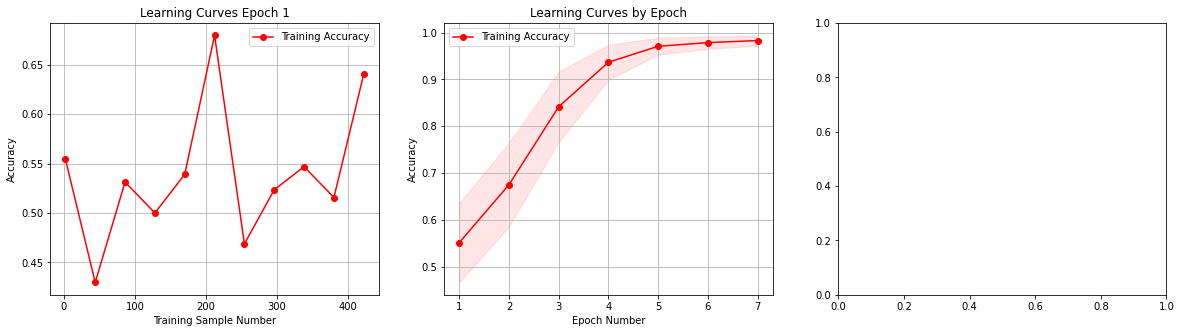

In [ ]:
#################
dataTrain_File = "/content/drive/MyDrive/Data_ANN_Crack_Detection/dataTrain.txt"
first.trainModel(nEpoch = 7, savePath = loadPath_final, debbugMode = False, debbugFile_Path = dataTrain_File)

#Model Testing

Using the Testing Data the Model was finally tested on wich it presented an amazing performance compared only with an ideal estimator.

The high values of Precision, Recall and F1-Score are a good measure to confirm that the model didn't achieve Overfitting not presents more tendencies of performance towards some Label.

The Model also presented secured in the sense that misclassification was higher on "Negative" Label Images. This shows that the model is more conservative when classifying an Image as a Non-Crack.

************************************************************
Model Testing
Test Accuracy Av: 0.8214 Loss Av: 0.0004682 Time: 1.0min 47.5seg
Finished Training
************************************************************


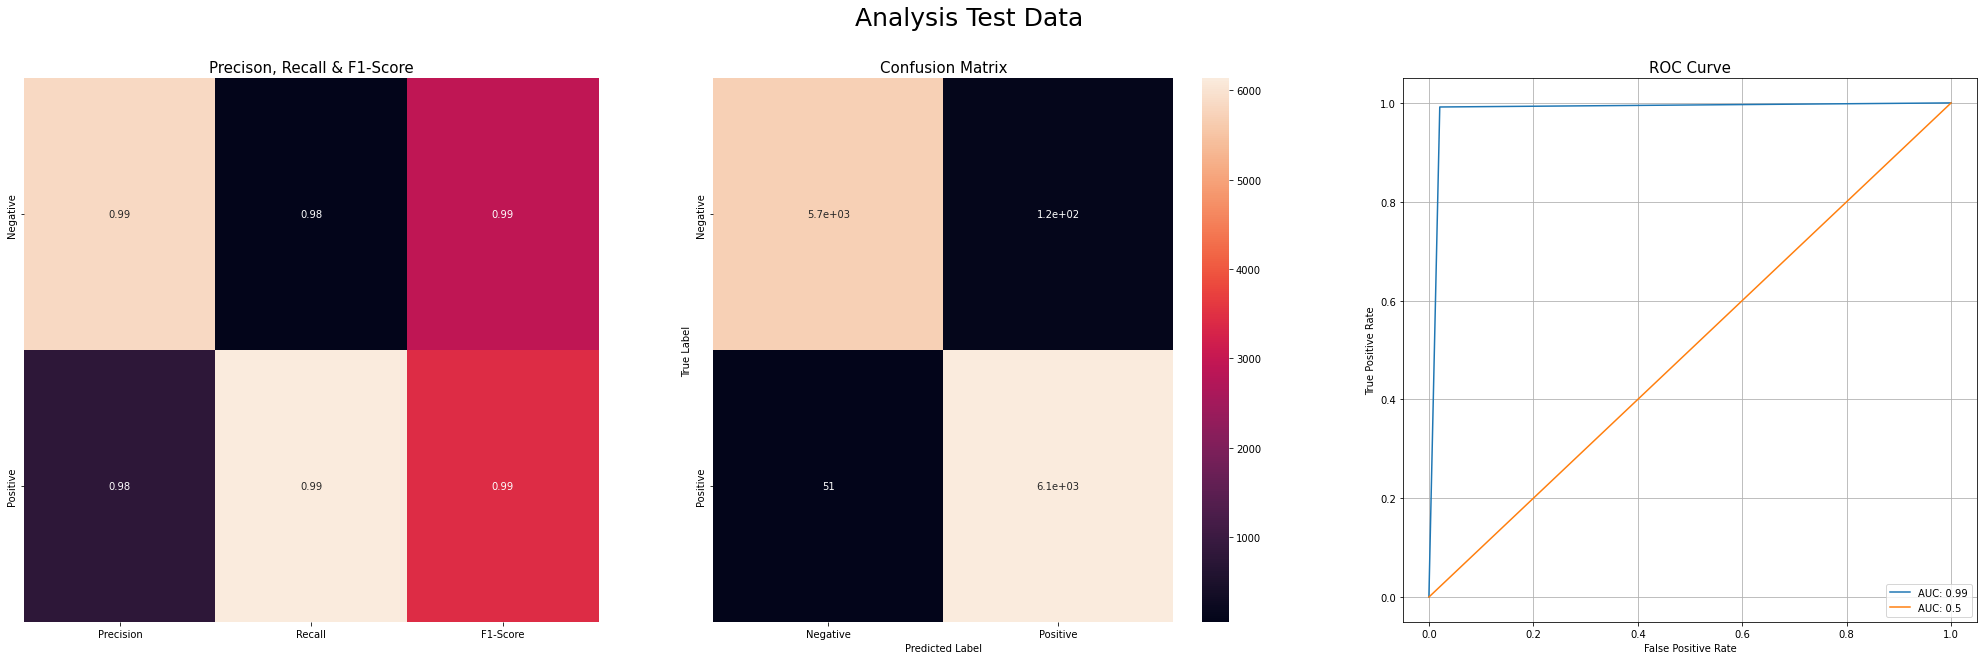

In [ ]:
first.testModel()

#Transfer Learning

Transfer Learning could've also being applied for this problem by directly testing a model.

For this case we will use the model ResNet-50.

In the first glance it is a much more complex model capable of making predictions on far more subjects. Due to that it will be imported pre-trained due to time and hardware limitations. When tested, this model presented much higher testing time.

Due to the complexity of this model and, by consequence the time it takes for making computations, it will not be used.

In [16]:
resNet = torchvision.models.resnet50(pretrained = True)
resNet_path = "/content/drive/MyDrive/Data_ANN_Crack_Detection/resNet_Model.pth"
torch.save(resNet.state_dict(), resNet_path)

resNet_Model = Model(baseModel = resNet, load = False)

dataset_final = customDataset(dataset = dataset, mode = "Imagem", augementation = False, YColumn = "Label", YLabel_Column = "Label", batch_size = 128)

resNet_Iteration = Iteration(resNet_Model, dataset_final, data_type = "Imagem", problema = "Classificacao", tipo = "Supervised")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
torchsummary.summary(resNet, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
resNet_Iteration.testModel()

#Benchmarking
TODO

#Model Predict Test
In this seccion a Sample of Images was created in order to actually see the predictions made by the model.
Only Images of "Positive" Label were used as they are the most critical ones for this program.


In [ ]:
predictTest_dataset = dataset.loc[dataset["Label"] == "Positive"].sample(10)
predictTest_dataset.head()

Filepath     Label
6740   /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
5270   /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
15223  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
16455  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
8640   /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive

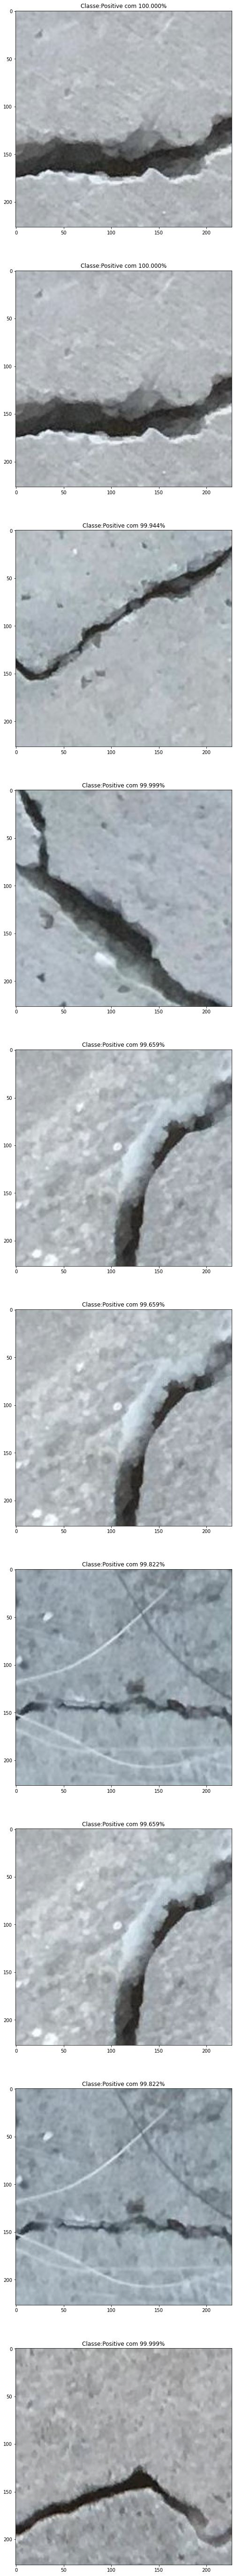

In [ ]:
predict = first.modelPredict(predictTest_dataset, nSampleShow = 10, imgPathColumn = "Filepath")

#Robust Testing
To finalize, the model is tested with a completly new and unseen dataset and an evaluation is made in order to see if the model can be applied to real-world cases in the same conditions.

The used Dataset named "Structural Defects Network (SDNET 2018)" was also finded in Kaggle: https://www.kaggle.com/datasets/aniruddhsharma/structural-defects-network-concrete-crack-images

It contains various images in various structures. In this case, the Cracks on walls were used for testing. It includes as narrow as 0.06 mm and as wide as 25 mm. This Dataset was fairly unbalanced with was the main reason for not being used in the Training Section.

The presented Images it contains however have some similarities with the first one.


---

The model performed very bad seeing that this data was unknown by it as we can see by the Precision, Recall and F1-Score values. It is possible to conclue that the model was in fact predicting every sample to be a Non-Crack. From the ROC Curve, with this data, this model was basicly a Toss a Coin estimator.
Again, a prediction was visualized in order to see the model operating.


Text(0.5, 1.0, 'Sample Class Negative')

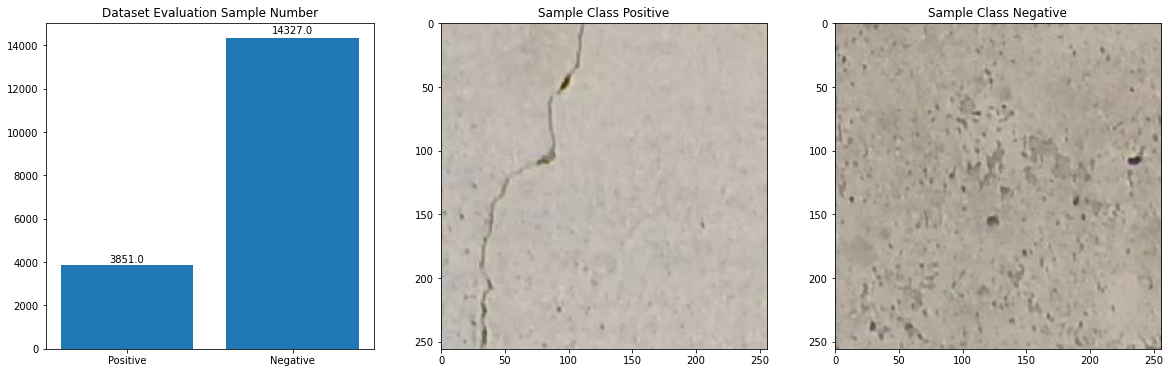

In [15]:
dataset_eval_path = "/content/drive/MyDrive/Data_ANN_Crack_Detection/Structural Defects Network (SDNET) 2018/Walls"


positiveDataset_eval = generate_dataset(pathlib.Path("{0}/Positive".format(dataset_eval_path)), 'Positive')
negativeDataset_eval = generate_dataset(pathlib.Path("{0}/Negative".format(dataset_eval_path)), 'Negative')

dataset_eval = pandas.concat([positiveDataset_eval, negativeDataset_eval], ignore_index = False)

fig, axes = matplotlib.pyplot.subplots(1,3, figsize = (20,6))

plot = axes[0].bar(["Positive", "Negative"], [positiveDataset_eval.shape[0], negativeDataset_eval.shape[0]])


imgPos_Eval_path = positiveDataset_eval.iloc[0]["Filepath"]
imgNeg_Eval_path = negativeDataset_eval.iloc[0]["Filepath"]

imgPos_eval = cv2.imread(imgPos_Eval_path)
imgNeg_eval = cv2.imread(imgNeg_Eval_path)


axes[1].imshow(imgPos_eval)
axes[2].imshow(imgNeg_eval)

for rect in plot:
  height = rect.get_height()
  axes[0].text(rect.get_x() + rect.get_width()/2, 1.01*height, "{0:.1f}".format(height), ha = "center", va = "bottom")

axes[0].set_title("Dataset Evaluation Sample Number")
axes[1].set_title("Sample Class Positive")
axes[2].set_title("Sample Class Negative")

In [ ]:
predictDataset_eval = dataset_eval.loc[dataset_eval["Label"] == "Positive"].sample(10)
predictDataset_eval.head()

Filepath     Label
1408  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
1851  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
1294  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
218   /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
2856  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive

************************************************************
Model Evaluation
Predict Accuracy Av: 0.4148 Loss Av: 0.7395 Time: 5.0min 56.7seg
Finished Evaluation
************************************************************


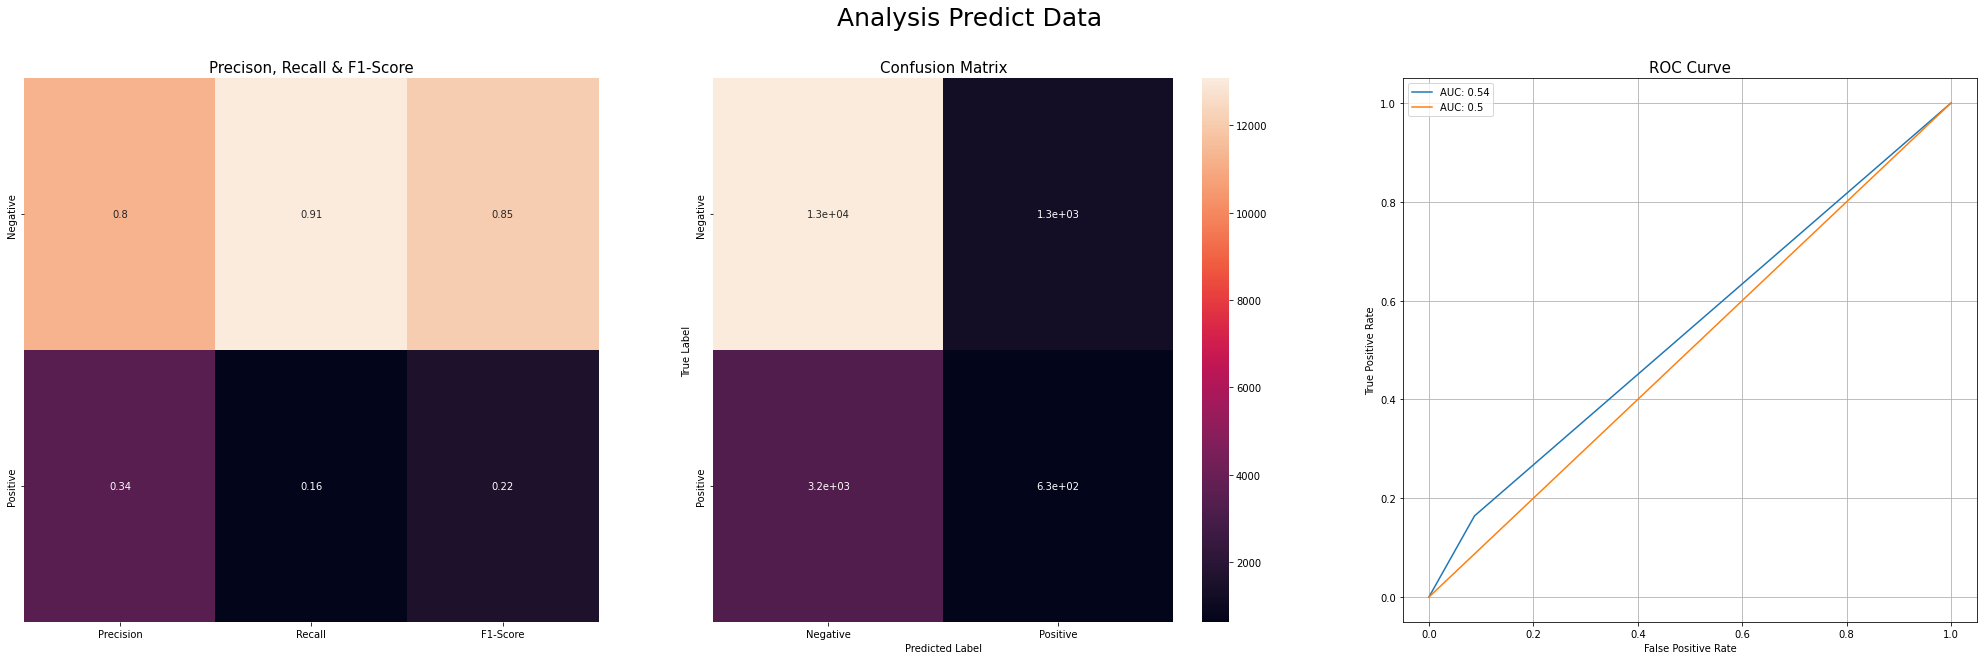

In [ ]:
first.modelEval(dataset_eval, YLabel_Column="Label")

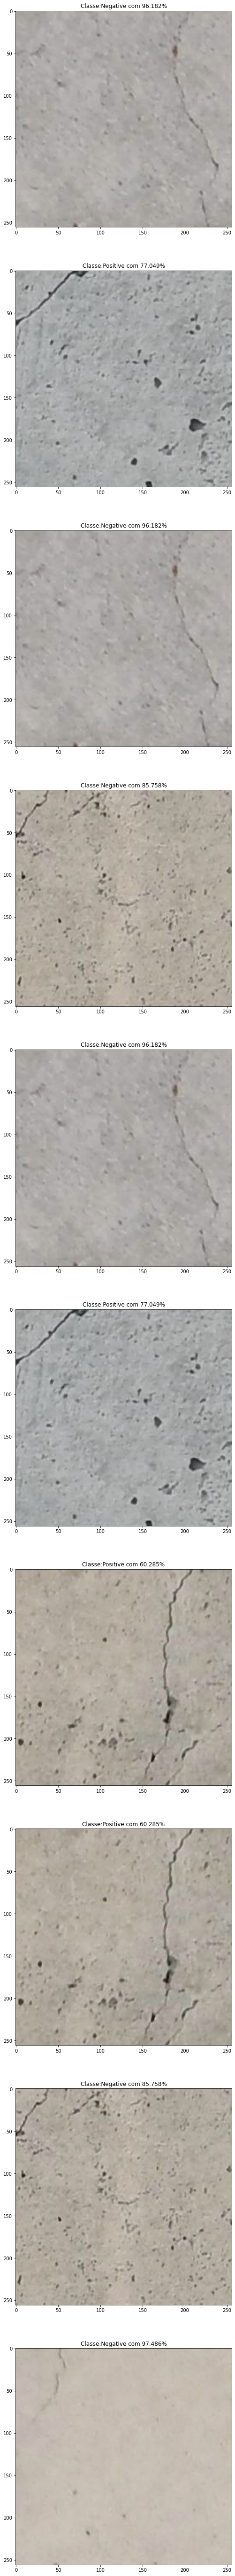

In [ ]:
predict = first.modelPredict(predictDataset_eval, nSampleShow = 10, imgPathColumn = "Filepath")

#Crack Parameters

Being that the model passed all the performance tests it is now necessary the extraction of Features of the Cracks.
This would allow to perform temporal analysis on the cracks and detect if it is increasing and repair would be needed



---



For this a Mask of the Color Black was applied followed by a Gaussian Filter and Morphological Operations.

An Edge detection approach was also studied but deemed uneffective as a high number of edges were always detected.

On the final mask Image, Skeletonization was applying by constructing a "tree" like structure and from this tree the longest path was used to calculate the Crack's Length.
By not having any information of the Camera nor having any reference Images this features are measured in Pixel Count.

This approach can produce very good results or very bad results depending on factors like the lighting, the type of crack, main color of the wall, etc

In [ ]:
crack_test = dataset.loc[dataset["Label"] == "Positive"]
crack_test.head()

Filepath     Label
0  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
1  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
2  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
3  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive
4  /content/drive/MyDrive/Data_ANN_Crack_Detectio...  Positive

In [ ]:
def getSkeleton(image, fig, axes, title):
  #Get Black Mask
  ###########################################################################

  #Range for black color
  back_lower = numpy.array([0, 0, 0], numpy.uint8)
  black_upper = numpy.array([125, 125, 125], numpy.uint8)

  black_mask = cv2.inRange(imagem, back_lower, black_upper)


  #Filter & Morphological Operations
  ###########################################################################


  gaussian1 = cv2.GaussianBlur(black_mask, (11,11), 0)

  ret,thresh1 = cv2.threshold(gaussian1, 120, 255, cv2.THRESH_BINARY)

  kernel_erode = numpy.ones((5, 5), numpy.uint8)
  kernel_dilate = numpy.ones((5, 5), numpy.uint8)

  #img_erosion1 = cv2.erode(thresh1, kernel_erode, iterations=1)
  img_dilation1 = cv2.dilate(thresh1, kernel_dilate, iterations=2)
  img_erosion2 = cv2.erode(img_dilation1, kernel_dilate, iterations=1)

  #Skeleton
  ###########################################################################

  #Normalization 0->0 & 255->1
  binary = img_erosion2 >= 1

  #print(numpy.unique(binary))

  skeleton = skimage.morphology.skeletonize(binary)

  #Show Images
  #############################################################################
  fig.suptitle(title)
  axes[0][0].imshow(imagem)
  axes[0][1].imshow(black_mask, cmap = "gray")
  axes[0][2].imshow(gaussian1, cmap = "gray")
  axes[0][3].imshow(thresh1, cmap = "gray")

  #axes[1][0].imshow(img_erosion1, cmap = "gray")
  axes[1][0].imshow(img_dilation1, cmap = "gray")
  axes[1][1].imshow(img_erosion2, cmap = "gray")

  skan.draw.overlay_skeleton_2d(binary, skeleton, dilate=0, axes = axes[1][2])

  axes[0][0].set_title("Original")
  axes[0][1].set_title("Black Mask")
  axes[0][2].set_title("Gaussian")
  axes[0][3].set_title("Threshold")

  #axes[1][0].set_title("Erosion 1")
  axes[1][0].set_title("Dilation")
  axes[1][1].set_title("Erosion")
  axes[1][2].set_title("Skeleton")

  return img_erosion2, skeleton

Mask Area: 6730 pixels


branch-distance  euclidean-distance
0       291.663997          251.077677

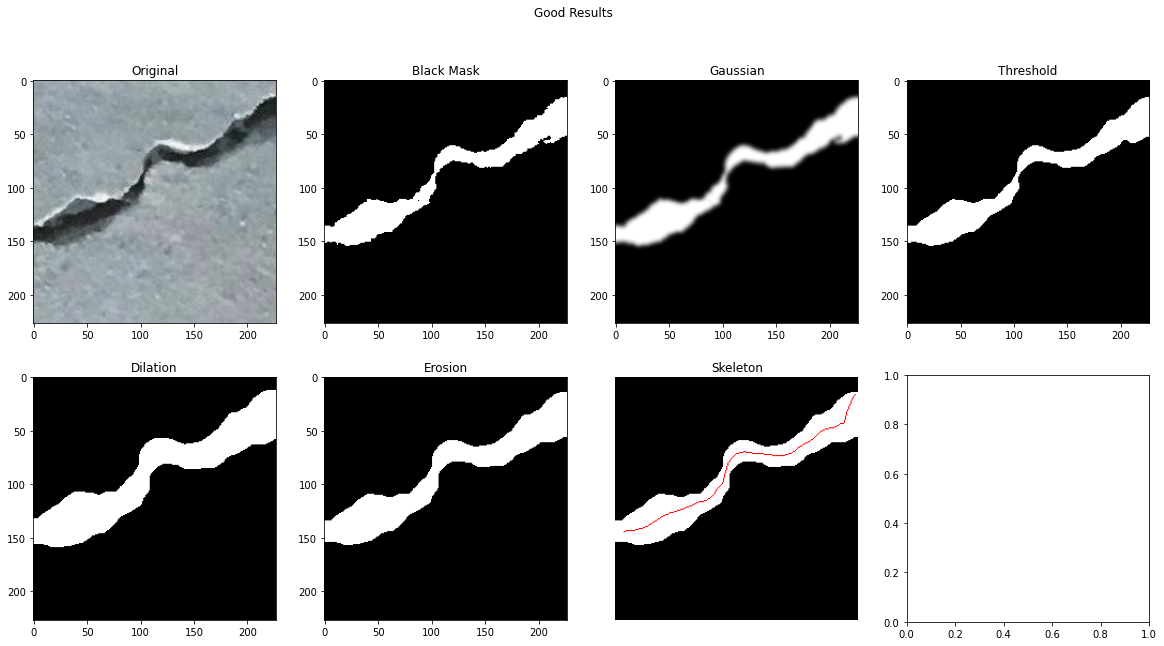

In [ ]:
fig1, axes1 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[56].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig1, axes1, "Good Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))
aux.head(3)

Mask Area: 7733 pixels


branch-distance  euclidean-distance
1       249.539105          223.503915
0         6.828427            6.000000
2         4.242641            4.242641

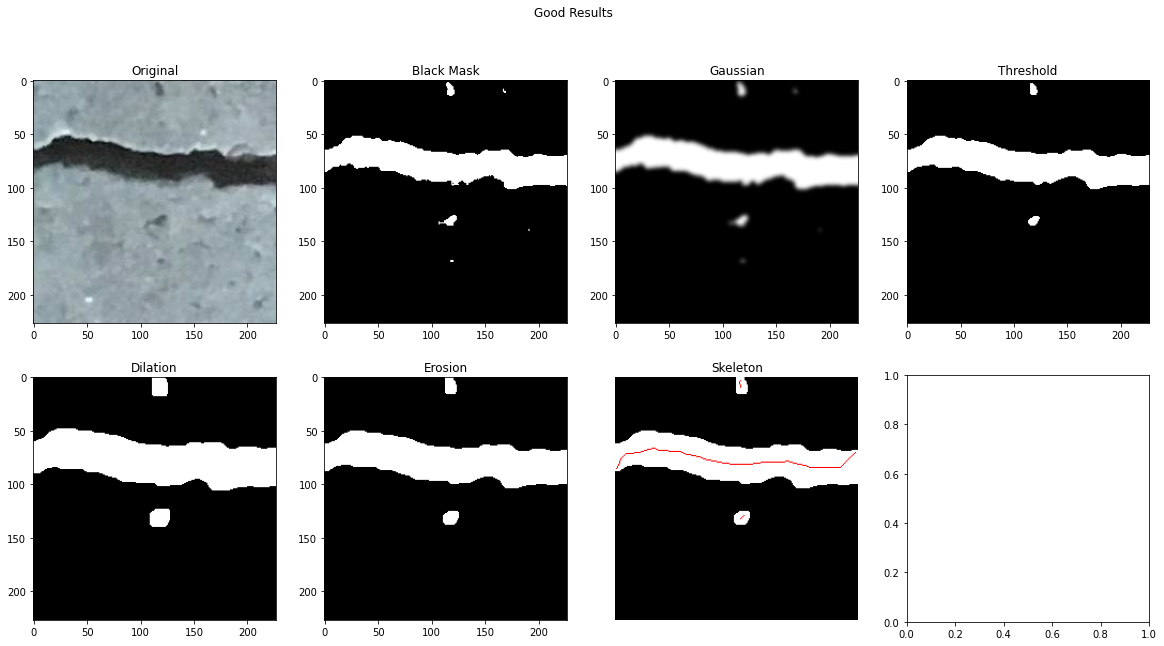

In [ ]:
fig2, axes2 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[98].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig2, axes2, "Good Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))

aux.head(3)

Mask Area: 14957 pixels


branch-distance  euclidean-distance
0       154.994949          138.600144
3       124.698485          105.475116
2        25.313708           22.360680

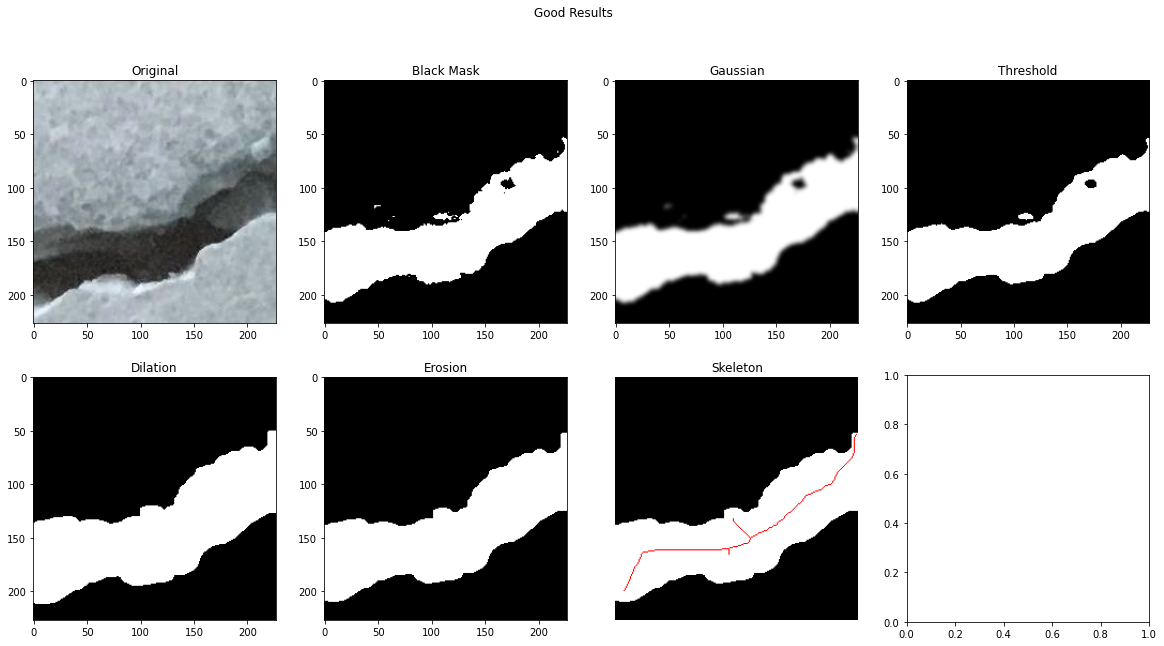

In [ ]:
fig3, axes3 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[5678].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig3, axes3, "Good Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))

aux.head(3)

Mask Area: 2434 pixels


branch-distance  euclidean-distance
8        84.497475           77.025970
1        47.870058           41.677332
7        34.870058           32.649655

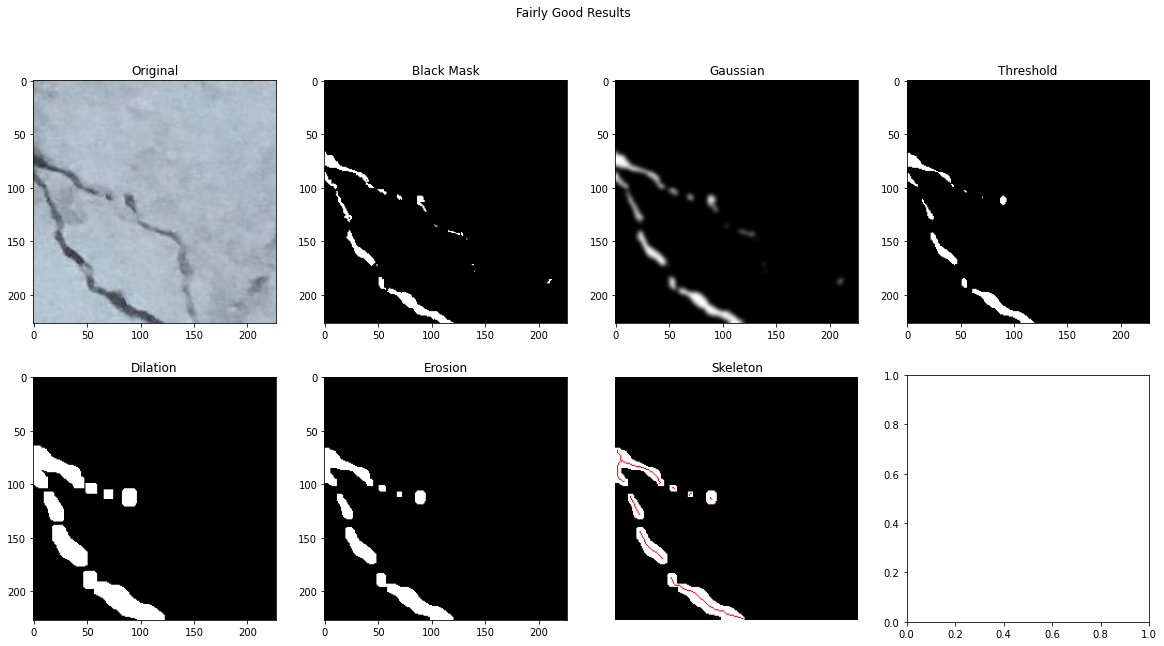

In [ ]:
fig3, axes3 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[4321].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig3, axes3, "Fairly Good Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))

aux.head(3)

Mask Area: 7064 pixels


branch-distance  euclidean-distance
3       138.870058          131.003817
7       135.225397          125.000000
6        84.870058           76.655072

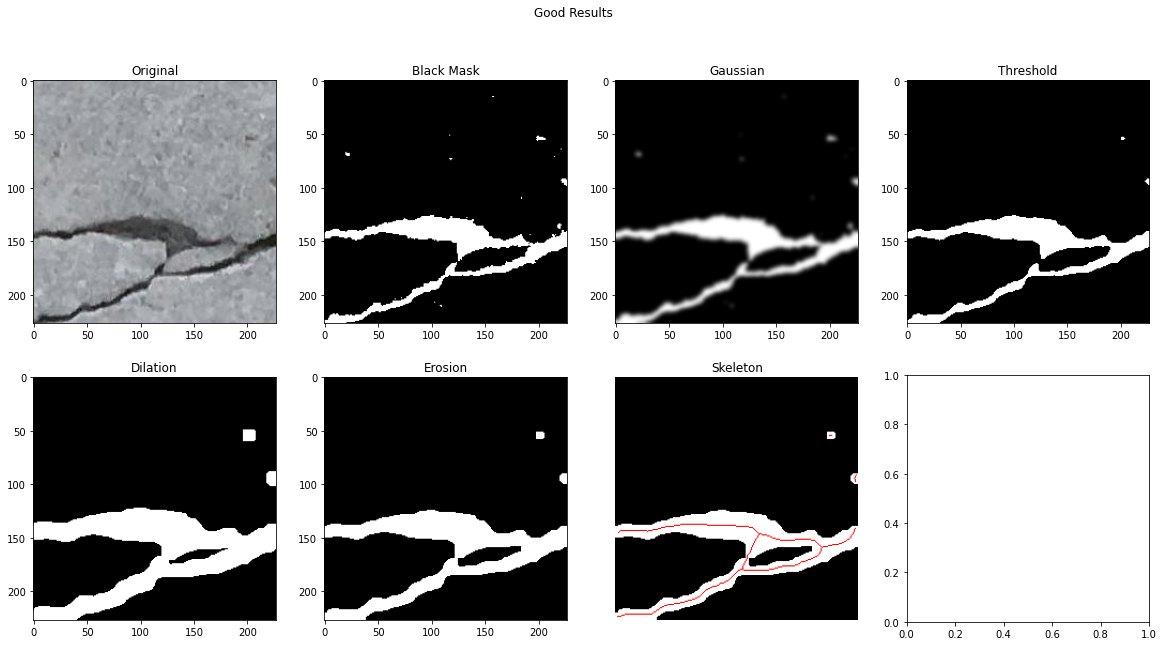

In [ ]:
fig3, axes3 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[4444].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig3, axes3, "Good Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))

aux.head(3)

Mask Area: 4692 pixels


branch-distance  euclidean-distance
1       272.019336          245.668476
0        50.870058           43.931765
2         2.414214            2.236068

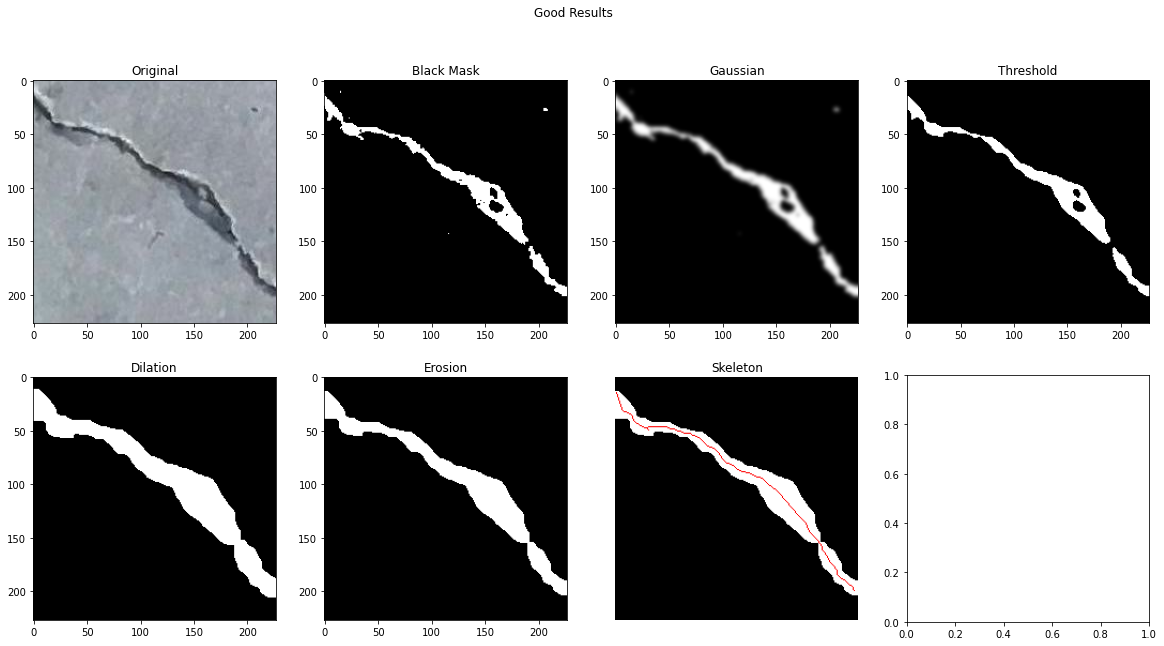

In [ ]:
fig3, axes3 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[2323].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig3, axes3 , "Good Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))

aux.head(3)

Mask Area: 40572 pixels


branch-distance  euclidean-distance
66        94.698485           76.006579
16        54.970563           50.990195
83        54.840620           51.855569

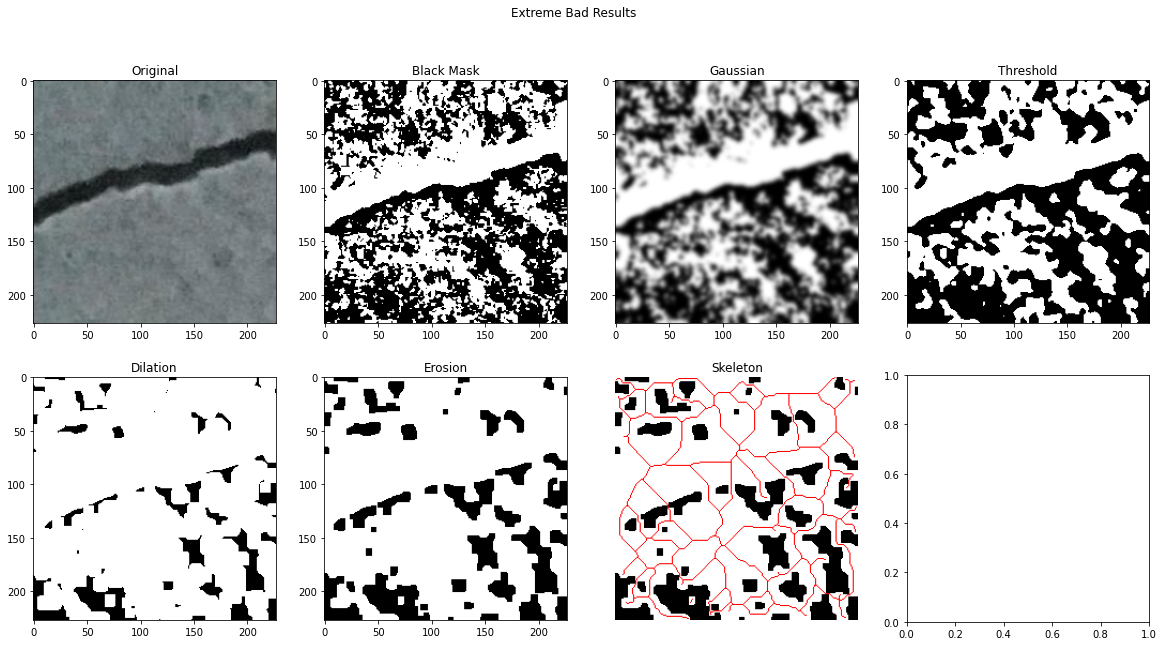

In [ ]:
fig3, axes3 = matplotlib.pyplot.subplots(2,4, figsize = (20,10))

imagem = cv2.imread(str(crack_test.iloc[1950].values[0]))

final_mask, skeleton = getSkeleton(imagem, fig3, axes3, "Extreme Bad Results")

#Skeleton Analysis
#############################################################################
skeleton_object = skan.Skeleton(skeleton)
statistics = skan.summarize(skeleton_object)
statistics = statistics.sort_values(by = "branch-distance",ascending = False).head(3)

aux = pandas.DataFrame()
aux["branch-distance"] = statistics["branch-distance"]
aux["euclidean-distance"] = statistics["euclidean-distance"]

print("Mask Area: {0} pixels".format(cv2.countNonZero(final_mask)))

aux.head(3)